# Forecasting time series with ARIMA

Firstly a little about what ARIMA, its actually just one of a family of autoregressive models which you can use in forecasting.  Depending on your particular data you will want to choose which parts of the model you want.

It stands for autoregressive integrated moving average but depending on your needs you might only need an auto-regressive model (AR) or moving average model (MA). or if your data is non-stationary you will need the integrated part (I) which means its fitting the differences in your data values instead of the values themselves.  If your data appears to have some seasonality compontent to it, you will use SARIMA, and if you are using additional exogenous variables this would be called SARIMAX.  There may even be other variations of this model.

There are strict assumptions which are made when using ARMA, which you can read about many places but the following are the most important.
 
1) Ensure the data isn't actually white noise, in which there is no structure to regress.  If its purely white noise, then just use the mean of the series since that is the best estimate you can make.
2) Ensure the data is stationary, that means there cannot be a slope or curve to the data over time, otherwise you need to transform the data prior to analysis.
3) Ideally there should be constant variance througout the series.  If there is a time dependent variance then the model may not fit very well.




In [73]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from datetime import datetime

In [3]:
#load daily data from Yahoo Finance
# download dataframe
data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2019-01-01")


[*********************100%***********************]  1 of 1 downloaded


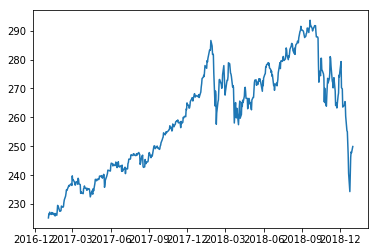

In [4]:
#Visualize to familiarize ourselves with it
plt.plot(data['Close'])

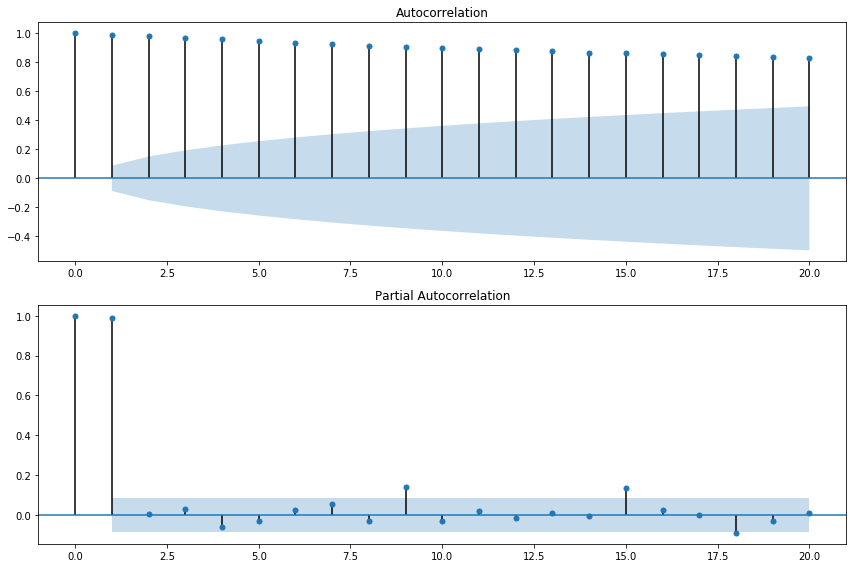

In [5]:
#Explore the data for autocorrelation and partial autocorrelation
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Close'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Close'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

Evaluating the above ACF and PACF will decide what type of model you will need.

ACF    | PACF | Model  |
-------|------|--------|
    Spikes decay towards zero | Spikes cutoff to zero | AR(p)
    Spikes cutoff to zero | Spikes decay towards zero | MA(q)
Spikes decay towards zero | Spikes decay towards zero | ARMA(p,q)

If you have seasonality then add S

If you have non-stationary data then add I

In [6]:
# Plot the four essential plots all at once

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    #sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x235266e9eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x235262205c0>)

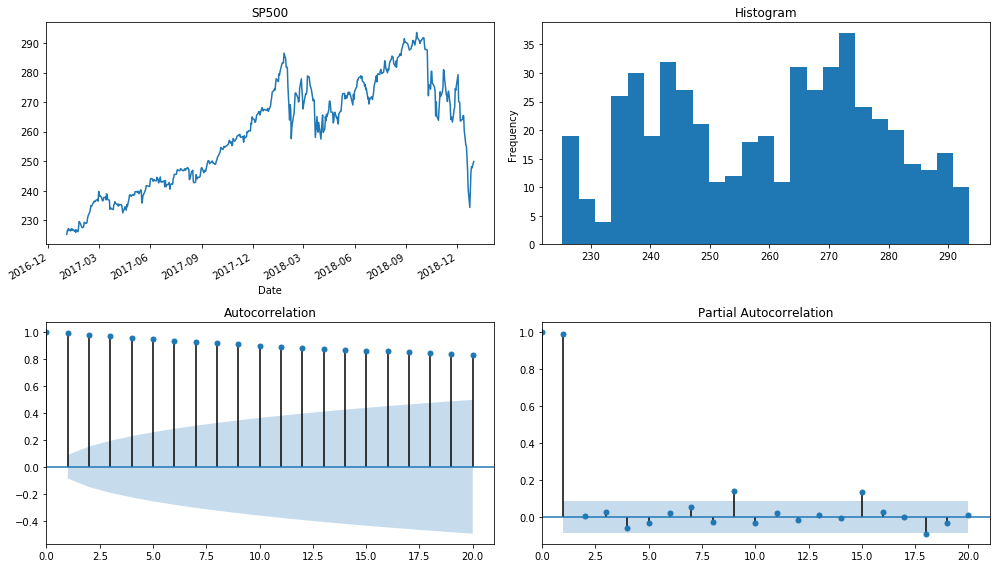

In [7]:
tsplot(data['Close'], title='SP500', lags=20)

We can see from the chart that this time series is non-stationary and is highly correlated over 20 lags.  The partial autocorrelation shows us that almost all of the autocorrelation can be reduced with a lag of 1, which is achievable by first differencing.

(<matplotlib.axes._subplots.AxesSubplot at 0x2352b6001d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2352b725128>)

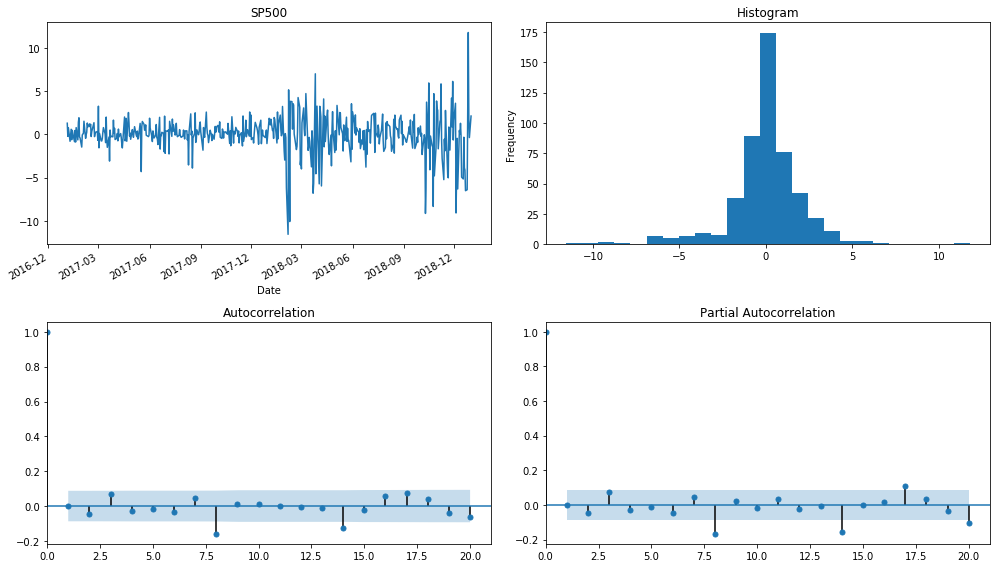

In [304]:
#Make the data stationary using first differences.
dtrans = data['Close'].diff().dropna()

#Remove the mean, even though it appears to be nearly zero
dtrans -= dtrans.mean()

#Lets re-evaluate
tsplot(dtrans, title='SP500', lags=20)

This looks much better and is now suitable for use in ARIMA.

In [305]:
#Split the dataset into a train and test set to evaluate the performance of the forecast.
tenpercent = int(dtrans.size * 0.10 )
train, test = dtrans[:-tenpercent], dtrans[-tenpercent:]

In [311]:
# Fit the model

#The order is important, which represents the p, q, r parameters.

arima200 = sm.tsa.SARIMAX(train, order=(1,1,0))
model_results = arima200.fit()
model_results.summary()

C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  451
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1020.982
Date:                Tue, 19 Feb 2019   AIC                           2045.964
Time:                        21:13:49   BIC                           2054.183
Sample:                             0   HQIC                          2049.204
                                - 451                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4677      0.024    -19.419      0.000      -0.515      -0.420
sigma2         5.4699      0.158     34.579      0.000       5.160       5.780
===================================================================================
Ljung-Box (Q):                      202.86   Jarque-Bera (JB):              1432.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

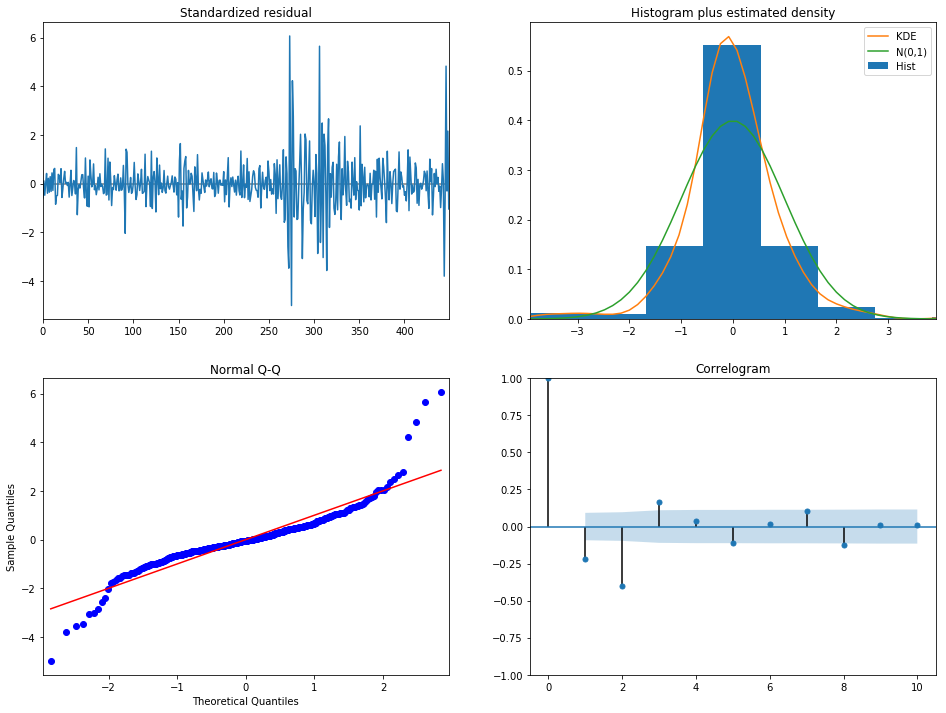

In [312]:
#Conduct visual inspection of the results
#Note this method is only available on SARIMAXResults objects (seems like a bug)
model_results.plot_diagnostics(figsize=(16, 12));

In [84]:
#data.index is a DatetimeIndex with dtype='datetime64[ns]'
#train.index is a DatetimeIndex with dtype='datetime64[ns]'
#train.index[0] is a Timestamp
#test.index is a DatetimeIndex with dtype='datetime64[ns]'
#est.index[0] is a Timestamp



Timestamp('2018-10-18 00:00:00')

In [265]:
#train.index.dtype
#train['2017-01-04']
pred_begin = train.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]

#datetime.strptime(pred_begin, '%Y-%m-%d')
#train[pred_begin.strftime('%Y-%m-%d')]

#Lets produce a string
#pred_begin.strftime('%Y-%m-%d')

#lets see if it can be used to index into our data
#train[pred_begin.strftime('%Y-%m-%d')]  #yes
#train[pred_begin.strftime('%Y-%m-%d 00:00:00')] #also yes



C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


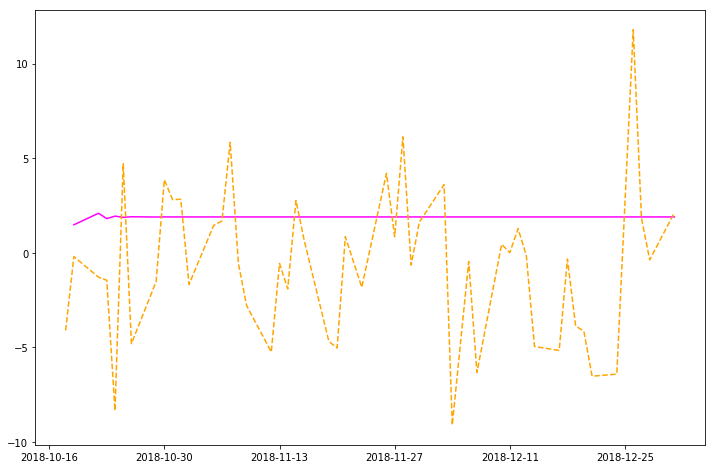

In [313]:
#train.index[model_results.loglikelihood_burn]
#pred_begin.strftime('%Y-%m-%d')
#test.index[-1]
#pred_end.strftime('%Y-%m-%d')
#model_results.loglikelihood_burn
#train.index[0]
#model_results.get_prediction(start=train.size).predicted_mean
#pred_mean
#pred_ci
#dtrans.index
#pred.predicted_mean

# yes DatetimeIndex

pred_begin = train.index[0]
pred_end = train.index[-1]
#test.index[0]
#pred_end
#pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'))
#pred_begin


#model_results.predict(start=pred_begin, end=pred_end, typ='levels')
#When we pass a Timestamp into predict it gives the error "TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'"
#So lets give a string


#model_results.predict( start=pred_begin.strftime('%Y-%m-%d 00:00:00'), end=pred_end.strftime('%Y-%m-%d 00:00:00'), typ='levels')
#KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'
#Oh, does this mean it cannot find it in train???
#train.index[50]
#no because if I use train it works there.


#When I use integers I get a result from 2017-01-5 - 2017-02-16

#model_results.predict(0, 450, typ='levels')

#pred = model_results.get_prediction(0, 455)

#Predict will allow you to test out-of-sample data
#model_results.predict(0, 500, typ='levels')
pred = model_results.get_prediction(0, 500)

#If the end time is beyond the end of the training its index is an int.

#So the problem is, it cannot predict the datetimes that will appear in the future, because it
#doesn't know the frequency of the datetimes, so we need to generate those datetimes for it
#or maybe if we specify a custom frequency then it can generate the dates itself.

#for now, since we actually know the future dates since they are the index to the out-of-sample data
#we will reference those.

#pred.predicted_mean
#outofsampleforecast = pd.DataFrame(data=pred.predicted_mean[1:,1:],    # values
#            index=pred.predicted_mean[1:,0],    # 1st column as index
#            columns=pred.predicted_mean[0,1:])

#pred.predicted_mean


pdf= [(dtrans.index[i].strftime('%Y-%m-%d') ,x) for i,x in enumerate(pred.predicted_mean)]


predicted = pd.DataFrame({'Mean':pred.predicted_mean})
#predicted['Date'] = dtrans.index

#index = train.index .concat(test.index)
#predicted = pd.DataFrame(data=pdf[1,:], index=pdf[0,:], columns=['PredictedMean'])
predicted.set_index(dtrans.index, inplace=True)
#predicted

#plot predicted
plt.plot(predicted[predicted.index>'2018-10-18'], color='Magenta')
#predicted[predicted.index>'2018-10-15']

#plot test
plt.plot(test, color='orange', linestyle='--')


#Notable: The average prediction isn't zero, it approaches a constant.




C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


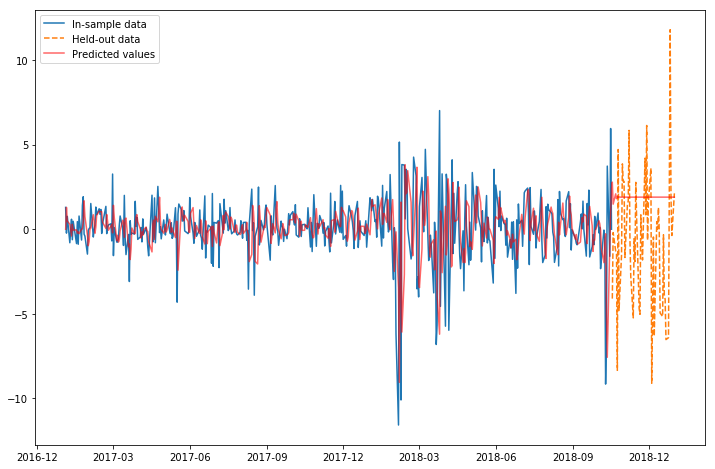

In [314]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = train.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]

#Lets get a prediction on in-sample data
#pred = model_results.predict(0, 450, typ='levels')
#pred = model_results.get_prediction(0, 450)

#We will get our prediction for the whole train and test time period.
#But because this module doesn't project dates into the future it returns periods as an int.
#So we will reassociate with dates
pred = model_results.get_prediction(0, 500)
predicted = pd.DataFrame({'Mean':pred.predicted_mean})
predicted.set_index(dtrans.index, inplace=True)


#get_prediction doesn't work with datatimes, or datestrings
#pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'))
#pred = model_results.get_prediction(start=model_results.loglikelihood_burn, end=dtrans.size)

#There is not method plot_predict on the model_results object (leading me to believe this is a change in the module)
#model_results.plot_predict(0, 450, dynamic=True, ax=ax1,plot_insample=False)

#But now how to we test on out-of-sample data?  Forecasting?

#forecast = model_results.forecast(steps=50)


#pred_mean = pred.predicted_mean

ax1.plot(predicted, 'r', alpha=.6, label='Predicted values')

pred_ci = pred.conf_int(alpha=0.05)

#ax1.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


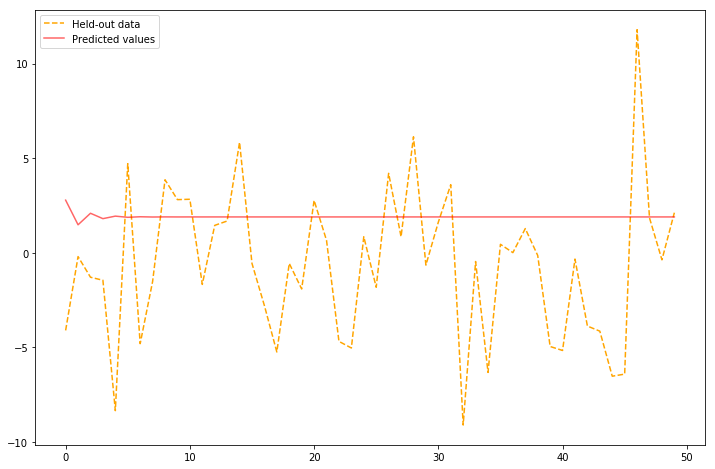

In [315]:
#Let's zoom in
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#Lets ignore dates to simplify plotting
ax1.plot(range(0,50), test, label='Held-out data', linestyle='--', color='orange')

pred = model_results.get_prediction(451, 500)

ax1.plot(range(0,50), pred.predicted_mean, 'r', alpha=.6, label='Predicted values')

ax1.legend(loc='best');

# Summary

There is also a possibility the module is not functioning correctly.  Further testing should be done.

It also appears to be overfitting the training data and not making very good forecasts, something is still wrong.